# 5600 Electrical Layout Creation

Goal:

* Create an electrial layout mapping table between hostnames to MSBs
* Cleanup the per MSB raw data, zip and compile in one single pandas dataframe

# Setup

## Dependencies

In [1]:
!conda install -y -c conda-forge pyarrow python-snappy

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pyarrow
    - python-snappy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    arrow-cpp-3.0.0            |py38h6da0e5f_9_cpu        20.9 MB  conda-forge
    aws-c-cal-0.4.5            |       h76129ab_8          35 KB  conda-forge
    aws-c-common-0.5.2         |       h7f98852_0         165 KB  conda-forge
    aws-c-event-stream-0.2.7   |       h6bac3ce_1          47 KB  conda-forge
    aws-c-io-0.9.1             |       ha5b09cb_1         119 KB  conda-forge
    aws-checksums-0.1.11       |       h99e32c3_3          50 KB  conda-forge
    aws-sdk-cpp-1.8.151        |       hceb1b1e_1 

## Dask cluster setup

In [2]:
# Cleanup
try:
    client.shutdown()
    client.close()
except Exception as e:
    pass

In [3]:
# Setup block
import os
import pwd
import glob
import pandas as pd
from distributed import LocalCluster, Client
import dask
import dask.dataframe as dd

LOCALDIR = "/tmp/dask"

In [4]:
dask.config.set({'worker.memory': {'target': False, 'spill': False, 'pause': 0.8, 'terminate': 0.95}})

In [5]:
# Cluster creation
cluster = LocalCluster(processes=True, n_workers=2, threads_per_worker=8,
                       dashboard_address=":8787", local_directory=LOCALDIR,
                       memory_limit="16GB")

client = Client(cluster)
cluster
client

Client Scheduler: tcp://127.0.0.1:45241 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 16 Memory: 32.00 GB


=========================================
# Layout mapping

The layout mapping is in th 5600 CircuitBreaker Matrix pdf file.
MSB17, MSB19, MSB20 will be useful for isolating measurement.

MSB18 and MSB16 that are related to "H" rows will make the isolation tricky as MSB18 includes compute cabinet H49 & H50.

Compute rack related MSBs
* MSB16: Cabinets - H09 ~ G36 / Circuit 16-01 ~ 16-64
* MSB17: Cabinets - F01 ~ D03 / Circuit 17-01 ~ 17-64
* MSB19: Cabinets - D04 ~ B08 / Circuit 19-01 ~ 19-64
* MSB20: Cabinets - B09 ~ A36 / Circuit 20-01 ~ 20-64

Special MSB that includes H49 / H50 & the network switches & file system
* MSB18: Cabinets - H41 ~ C48 / Circuit 18-09, H-49/50, PDUs/DPs, 18-1, 18-2, 18-3, 18-4, 18-6

A separate MSB that measures the AIRforce system
* MSB21: Cabinets - A41 ~ A49 / Circuit 21-1 ~ 21-14

In [14]:
# Layout mapping in terms of Python Dictionary isolating MSBs related to Summit compute
import pandas as pd
msb_map = {
    "16": [f"h{i:02}" for i in range(9, 36+1)]
        + [f"g{i:02}" for i in range(1, 36+1)],
    "17": [f"f{i:02}" for i in range(1, 36+1)]
        + [f"e{i:02}" for i in range(1, 13+1)]
        + [f"e{i:02}" for i in range(25, 36+1)]
        + ["d01", "d02", "d03"],
    "19": [f"d{i:02}" for i in range(4, 17+1)] + [f"d{i:02}" for i in range(19, 32+1)] + ["d34", "d35", "d36"] 
        + [f"c{i:02}" for i in range(1, 13+1)] + [f"c{i:02}" for i in range(25, 36+1)]
        + [f"b{i:02}" for i in range(1, 8+1)],
    "20": [f"b{i:02}" for i in range(9, 36+1)] 
        + [f"a{i:02}" for i in range(1, 36+1)],
}
table = {
    "msb": [],
    "cabinet": [],
    "hostname": [],
}

for msb, row in msb_map.items():
    for cabinet in row:
        for node_id in range(1, 18 + 1):
            table["msb"].append(f"msb{msb}")
            table["cabinet"].append(cabinet)
            table["hostname"].append(f"{cabinet}n{node_id:02}")
msb_host_df = pd.DataFrame(table).set_index("hostname")
msb_host_df

,msb,cabinet
hostname,,
h09n01,msb16,h09
h09n02,msb16,h09
h09n03,msb16,h09
h09n04,msb16,h09
h09n05,msb16,h09
...,...,...
a36n14,msb20,a36
a36n15,msb20,a36
a36n16,msb20,a36


In [17]:
# Total count should reflect w hat we should have as # of nodes
cabinet_count = msb_host_df['cabinet']
node_count = len(msb_host_df['msb'])
print(f"Cabinets {cabinet_count}, Nodes {node_count}")

Cabinets hostname
h09n01    h09
h09n02    h09
h09n03    h09
h09n04    h09
h09n05    h09
         ... 
a36n14    a36
a36n15    a36
a36n16    a36
a36n17    a36
a36n18    a36
Name: cabinet, Length: 4608, dtype: object, Nodes 4608


In [20]:
# Exporting as a file
OUT_FN = "/gpfs/alpine/stf218/proj-shared/data/lake/summit_k100_electrical/5600-k100-electrical-mapping.parquet"
msb_host_df.to_parquet(OUT_FN, engine="pyarrow")

## MSB electrical readings

We load and convert the MSB electrical readings into a single file.
Also, we convert the timestamps which were in US/Eastern into UTC and retain the name.

In [88]:
import pandas as pd
# Read timestamp index in UTC
FIRST_MSB_FILE = f"/gpfs/alpine/stf218/proj-shared/data/lake/summit_k100_electrical/data/20210114_20210115/MSB16.csv"
MSB_OUTPUT = "/gpfs/alpine/stf218/proj-shared/data/lake/summit_k100_electrical/data/20210114_20210115/msb_readings.parquet"
df = pd.read_csv(FIRST_MSB_FILE)
timestamp_idx = (
        df['DATE'] + " " + df['TIME']
).astype('datetime64[ns, US/Eastern]').dt.tz_convert('UTC')

# Read each MSB
zipped = {}
for MSB_ID in [16, 17, 18, 19, 20]:
    df = pd.read_csv(f"/gpfs/alpine/stf218/proj-shared/data/lake/summit_k100_electrical/data/20210114_20210115/MSB{MSB_ID}.csv")
    zipped[MSB_ID] = df[f'B5600_MSB{MSB_ID}_MTR\\1s\\KW\\Total'].astype("float32")
msb_readings_df = pd.DataFrame({
    "timestamp": timestamp_idx,
    "msb16": zipped[16],
    "msb17": zipped[17],
    "msb18": zipped[18],
    "msb19": zipped[19],
    "msb20": zipped[20],
}).set_index('timestamp')
msb_readings_df.to_parquet(MSB_OUTPUT, engine="pyarrow")
msb_readings_df

,msb16,msb17,msb18,msb19,msb20
timestamp,,,,,
2021-01-14 05:00:00+00:00,1070.428223,1110.417114,681.995117,1115.381714,1132.671509
2021-01-14 05:00:01+00:00,1058.382812,1094.957397,676.349976,1101.303101,1123.147583
2021-01-14 05:00:02+00:00,1063.520386,1099.105103,671.715271,1101.324829,1128.026855
2021-01-14 05:00:03+00:00,1068.450195,1106.043579,681.131897,1101.088745,1128.333374
2021-01-14 05:00:04+00:00,1012.419006,1032.866455,682.884827,1032.796021,1067.869141
...,...,...,...,...,...
2021-01-16 04:59:55+00:00,1120.956665,1108.895264,740.591675,1109.908813,1125.879517
2021-01-16 04:59:56+00:00,1028.055908,1040.164673,744.213318,1035.005493,1055.702637
2021-01-16 04:59:57+00:00,1075.856689,1038.682129,740.826538,1051.618896,1059.070190


## Attempting mapping with a real summit OpenBMC data

In [26]:
import glob
import pandas as pd
DATE_KEY = "20200114"
MSB_MAPPING = "/gpfs/alpine/stf218/proj-shared/data/lake/summit_k100_electrical/5600-k100-electrical-mapping.parquet"
MSB_READINGS_TABLE = "/gpfs/alpine/stf218/proj-shared/data/lake/summit_k100_electrical/data/20210114_20210115/msb_readings.parquet"
MSB_OUTPUT = "/gpfs/alpine/stf218/proj-shared/data/lake/summit_k100_electrical/data/20210114_20210115/msb_readings.parquet"
SUMMIT_READINGS_TABLE = "/gpfs/alpine/stf218/proj-shared/data/lake/summit_k100_electrical/data/20210114_20210115/summit_readings.parquet"

In [27]:
# Limit the time range
def get_msb_level_power(datetime_key):
    """We split the day into three components and combine it later"""
    tbl = {
        '20210114': {
            'start': pd.to_datetime('2021-01-14 05:00:00Z'),
            'end':   pd.to_datetime('2021-01-14 23:59:59Z'),
            'file': "/gpfs/alpine/stf218/proj-shared/data/lake/summit_power_temp_openbmc/10s_agg/20210114.parquet",
        },
        '20210115': {
            'start': pd.to_datetime('2021-01-15 00:00:00Z'),
            'end':   pd.to_datetime('2021-01-15 23:59:59Z'),
            'file': "/gpfs/alpine/stf218/proj-shared/data/lake/summit_power_temp_openbmc/10s_agg/20210115.parquet",
        },
        '20210116': {
            'start': pd.to_datetime('2021-01-16 00:00:00Z'),
            'end':   pd.to_datetime('2021-01-16 04:59:59Z'),
            'file': "/gpfs/alpine/stf218/proj-shared/data/lake/summit_power_temp_openbmc/10s_agg/20210116.parquet",
        },
    }
    drange = tbl[datetime_key]
    start_time = drange['start']
    end_time = drange['end']
    file = drange['file']
    dataset_10s_ddf = dd.read_parquet(
        file,
        index='timestamp',
        columns=['hostname', 'total_power.mean', 'input_power.mean'],
        split_row_groups=True, engine="pyarrow")
    dataset_10s_ddf = dataset_10s_ddf[start_time : end_time]
    
    def handle_partition(df):
        """Handle 1 minute period"""
        df = pd.merge(df.reset_index(), pd.read_parquet(MSB_MAPPING), how='inner', on='hostname')
        ret_df = df.groupby(['timestamp', 'msb']).agg({'hostname': ['count'], 'total_power.mean': ['sum'], 'input_power.mean': ['sum']})
        return ret_df
    ret_df = dataset_10s_ddf.map_partitions(handle_partition, meta={
        ("hostname", "count"): "int64",
        ("total_power.mean", "sum"): "float32",
        ("input_power.mean", "sum"): "float32",
    }).compute()
    return ret_df

In [28]:
# Convert all three days
ddf_list = [get_msb_level_power(key) for key in ['20210114', '20210115', '20210116']]
ddf = pd.concat(ddf_list)

In [29]:
ddf.to_parquet(SUMMIT_READINGS_TABLE, engine="pyarrow")

In [30]:
ddf

hostname total_power.mean input_power.mean
                                   count              sum              sum
timestamp                 msb                                             
2021-01-14 05:00:00+00:00 msb16     1152     8.279308e+05      1248841.875
                          msb17     1152     8.382949e+05      1263408.875
                          msb19     1152     8.828622e+05      1269053.250
                          msb20     1152     8.534607e+05      1197323.625
2021-01-14 05:00:10+00:00 msb16     1152     1.082538e+06      1622864.750
...                                  ...              ...              ...
2021-01-16 04:59:40+00:00 msb20     1152     8.435222e+05      1195553.125
2021-01-16 04:59:50+00:00 msb16     1152     7.937040e+05      1236022.750
                          msb17     1152     8.067092e+05      1245748.250
                          msb19     1152     8.123554e+05      1214094.625
                          msb20     1152     8.220267e+05      1170748.000

[66644 rows x 3 columns]

# Joining with the MSB readings

In [31]:
import glob
import pandas as pd
SAMPLE_INTERVAL=10
DATE_KEY = "20200114"
MSB_MAPPING = "/gpfs/alpine/stf218/proj-shared/data/lake/summit_k100_electrical/5600-k100-electrical-mapping.parquet"
MSB_OUTPUT = "/gpfs/alpine/stf218/proj-shared/data/lake/summit_k100_electrical/data/20210114_20210115/msb_readings.parquet"
SUMMIT_READINGS_TABLE = "/gpfs/alpine/stf218/proj-shared/data/lake/summit_k100_electrical/data/20210114_20210115/summit_readings.parquet"

In [32]:
import pandas as pd
msb_df = pd.read_parquet(MSB_OUTPUT, engine="pyarrow").resample(pd.Timedelta(seconds=SAMPLE_INTERVAL)).mean()
msb_df

,msb16,msb17,msb18,msb19,msb20
timestamp,,,,,
2021-01-14 05:00:00+00:00,1173.888550,1244.161987,679.309692,1259.468506,1237.533325
2021-01-14 05:00:10+00:00,1352.007324,1461.237793,678.147888,1455.599609,1397.861450
2021-01-14 05:00:20+00:00,1068.418823,1108.542969,680.832520,1112.441040,1131.125122
2021-01-14 05:00:30+00:00,1060.525146,1106.379761,680.340210,1110.938354,1121.829346
2021-01-14 05:00:40+00:00,1052.437500,1107.741455,681.362122,1112.564575,1140.028442
...,...,...,...,...,...
2021-01-16 04:59:10+00:00,1085.760376,1100.641357,739.725159,1105.417236,1118.489136
2021-01-16 04:59:20+00:00,1088.098389,1107.974854,739.024658,1112.133911,1125.183105
2021-01-16 04:59:30+00:00,1101.444824,1119.457764,740.404968,1123.899170,1135.531372


In [33]:
summit_df = pd.read_parquet(SUMMIT_READINGS_TABLE, engine="pyarrow").unstack().resample(pd.Timedelta(seconds=SAMPLE_INTERVAL)).mean()

In [34]:
all_df = summit_df.join(msb_df, on='timestamp')
all_df

/opt/conda/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,"(hostname, count, msb16)","(hostname, count, msb17)","(hostname, count, msb19)","(hostname, count, msb20)","(total_power.mean, sum, msb16)","(total_power.mean, sum, msb17)","(total_power.mean, sum, msb19)","(total_power.mean, sum, msb20)","(input_power.mean, sum, msb16)","(input_power.mean, sum, msb17)","(input_power.mean, sum, msb19)","(input_power.mean, sum, msb20)",msb16,msb17,msb18,msb19,msb20
timestamp,,,,,,,,,,,,,,,,,
2021-01-14 05:00:00+00:00,1152.0,1152.0,1152.0,1152.0,8.279308e+05,8.382949e+05,8.828622e+05,8.534607e+05,1248841.875,1263408.875,1269053.250,1197323.625,1173.888550,1244.161987,679.309692,1259.468506,1237.533325
2021-01-14 05:00:10+00:00,1152.0,1152.0,1152.0,1152.0,1.082538e+06,1.176002e+06,1.184102e+06,1.115969e+06,1622864.750,1731778.250,1715049.875,1557559.500,1352.007324,1461.237793,678.147888,1455.599609,1397.861450
2021-01-14 05:00:20+00:00,1152.0,1152.0,1152.0,1152.0,7.874976e+05,8.218398e+05,8.273358e+05,8.397546e+05,1226085.375,1264622.500,1234028.250,1195878.000,1068.418823,1108.542969,680.832520,1112.441040,1131.125122
2021-01-14 05:00:30+00:00,1152.0,1152.0,1152.0,1152.0,7.854823e+05,8.209482e+05,8.277702e+05,8.343577e+05,1224204.125,1266596.500,1237253.500,1192493.375,1060.525146,1106.379761,680.340210,1110.938354,1121.829346
2021-01-14 05:00:40+00:00,1152.0,1152.0,1152.0,1152.0,7.739512e+05,8.196054e+05,8.260411e+05,8.447512e+05,1209546.750,1263815.000,1234057.750,1201183.125,1052.437500,1107.741455,681.362122,1112.564575,1140.028442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-16 04:59:10+00:00,1152.0,1152.0,1152.0,1152.0,7.983949e+05,8.149389e+05,8.229184e+05,8.346631e+05,1237852.625,1252853.125,1226416.375,1183707.250,1085.760376,1100.641357,739.725159,1105.417236,1118.489136
2021-01-16 04:59:20+00:00,1152.0,1152.0,1152.0,1152.0,8.040204e+05,8.206261e+05,8.278852e+05,8.381640e+05,1252016.125,1261663.375,1232473.125,1190323.000,1088.098389,1107.974854,739.024658,1112.133911,1125.183105
2021-01-16 04:59:30+00:00,1152.0,1152.0,1152.0,1152.0,8.246908e+05,8.356869e+05,8.416527e+05,8.510934e+05,1270550.875,1276760.625,1247238.375,1203472.875,1101.444824,1119.457764,740.404968,1123.899170,1135.531372


# Plot initialization

In [39]:
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# Initialize style
plt.style.use("acm_ieee_latex_pubstyle.txt")

SINGLE_COLUMN = SINGLE_WIDTH = 8.0
DOUBLE_COLUMN = DOUBLE_WIDTH = 16.0

def width_height(width=SINGLE_COLUMN, height=None, columns=1, rows=1):
    """Width driven sizing for seaborn multi-grid layouts
    
    Derive height & aspect kwargs for facetgrid, pairgrid & friends with a target sizing
    in terms of width and height.  Convenient for creating figures that has
    to be fit into a certain width, while maintaining the correct aspect ratios of the fonts.
    Call this function to derive the height & aspect
    
    Currently, ACM & IEEE latex, single column figure defaults to a width of 8inch
    and the double column figure defaults to a width of 8 inch for the correct text scaling
    
    Usage:
    - sns.FacetGrid( ... , **width_height())
    - sns.PairGrid( ..., **width_height(columns=X, rows=Y))

    :param width: target width in inches (4 inch for a single column figure is default)
    :param height: target heigth in inches (width * 3/4 - golden ratio is the default)
    :param columns: target # of columns for facetgrid
    :param rows: target # of rows for facetgrid
    """
    if height is None:
        height = width * 3/4
    ratio = float(width) / (float(height) / float(rows))
    return {"height": (float(width) / ratio), "aspect": ratio / float(columns)}

# Data loss

Data is lost in a similar fashion across the board.  Data from nodes are not seen when the power fluctuates with a large degree.  1152 nodes under MSBs should be seen but we have a graph that looks like below.

If we further look into the power curve, the data loss is somewhat synchronized with the power fluctuations.

In [7]:
loss_df = pd.DataFrame({
    'hosts_seen_msb16': all_df[('hostname', 'count', f'msb16')],
    'hosts_seen_msb17': all_df[('hostname', 'count', f'msb17')],
    'hosts_seen_msb19': all_df[('hostname', 'count', f'msb19')],
    'hosts_seen_msb20': all_df[('hostname', 'count', f'msb20')],
}, index=all_df.index)

<AxesSubplot:xlabel='timestamp'>

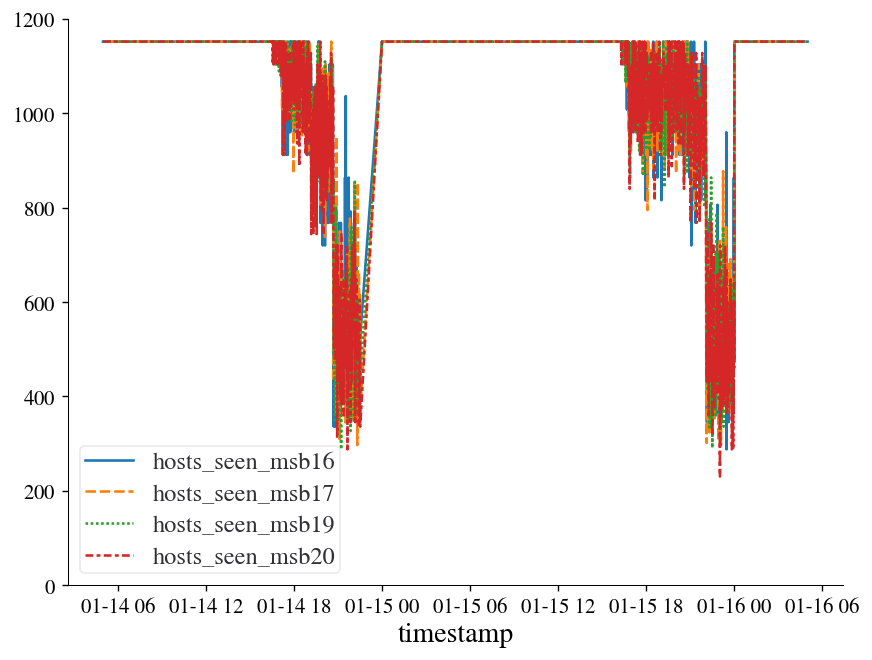

In [8]:
pal = dict(Lunch="seagreen", Dinner=".7")
data = loss_df[['hosts_seen_msb16', 'hosts_seen_msb17', 'hosts_seen_msb19', 'hosts_seen_msb20']].resample(pd.Timedelta(seconds=60)).mean()
sns.lineplot(data=data)

# MSB 16 Results

In [9]:
msb_id = '16'
msb_df = pd.DataFrame({
    'hostcount': all_df[('hostname', 'count', f'msb{msb_id}')],
    'total_power': all_df[('total_power.mean', 'sum', f'msb{msb_id}')] / 1000,
    'input_power': all_df[('input_power.mean', 'sum', f'msb{msb_id}')] / 1000,
    'msb_read': all_df[f'msb{msb_id}']
}, index=all_df.index)

<AxesSubplot:xlabel='timestamp'>

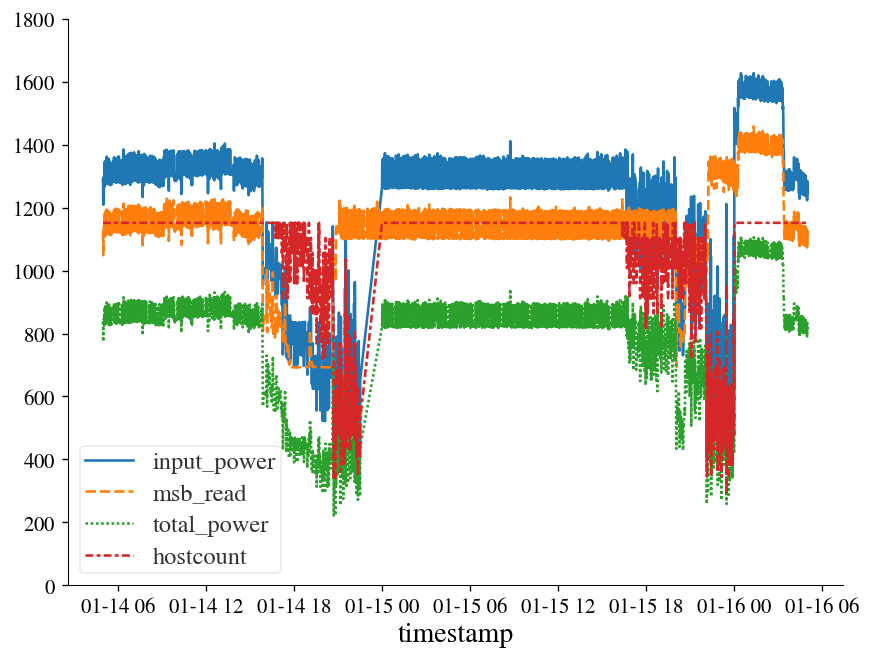

In [10]:
pal = dict(Lunch="seagreen", Dinner=".7")
data = msb_df[['input_power', 'msb_read', 'total_power', 'hostcount']].resample(pd.Timedelta(seconds=60)).mean()
sns.lineplot(data=data)

# MSB 17 Results

In [11]:
msb_id = '17'
msb_df = pd.DataFrame({
    'hostcount': all_df[('hostname', 'count', f'msb{msb_id}')],
    'total_power': all_df[('total_power.mean', 'sum', f'msb{msb_id}')] / 1000,
    'input_power': all_df[('input_power.mean', 'sum', f'msb{msb_id}')] / 1000,
    'msb_read': all_df[f'msb{msb_id}']
}, index=all_df.index)

<AxesSubplot:xlabel='timestamp'>

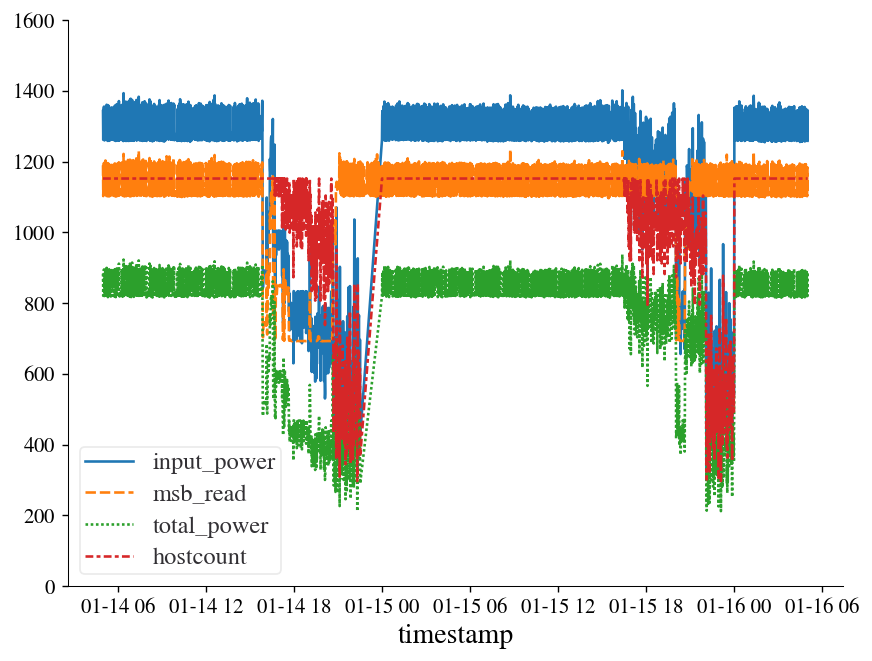

In [12]:
pal = dict(Lunch="seagreen", Dinner=".7")
data = msb_df[['input_power', 'msb_read', 'total_power', 'hostcount']].resample(pd.Timedelta(seconds=60)).mean()
sns.lineplot(data=data)

# MSB 19 Results

In [13]:
msb_id = '19'
msb_df = pd.DataFrame({
    'hostcount': all_df[('hostname', 'count', f'msb{msb_id}')],
    'total_power': all_df[('total_power.mean', 'sum', f'msb{msb_id}')] / 1000,
    'input_power': all_df[('input_power.mean', 'sum', f'msb{msb_id}')] / 1000,
    'msb_read': all_df[f'msb{msb_id}']
}, index=all_df.index)

<AxesSubplot:xlabel='timestamp'>

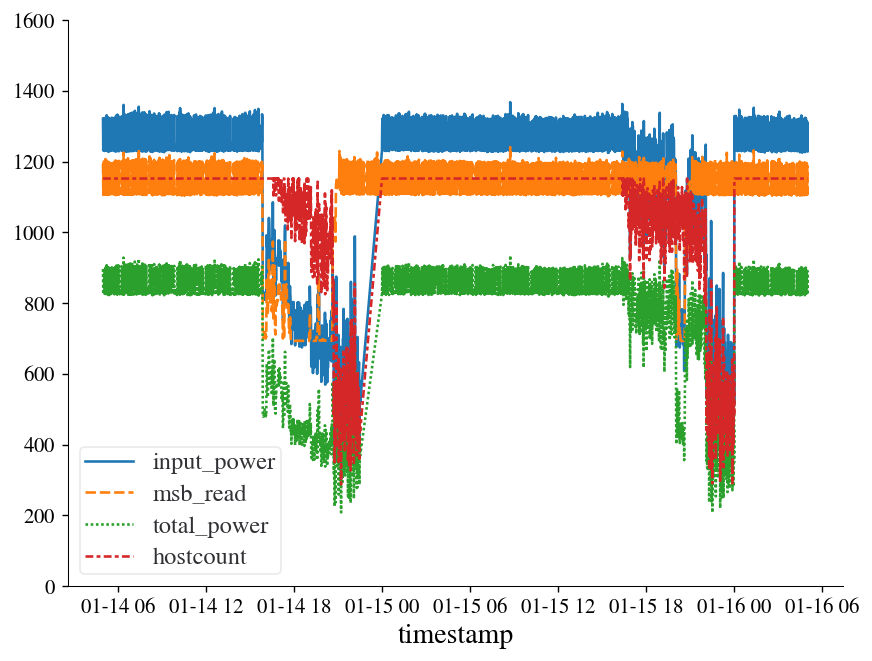

In [14]:
pal = dict(Lunch="seagreen", Dinner=".7")
data = msb_df[['input_power', 'msb_read', 'total_power', 'hostcount']].resample(pd.Timedelta(seconds=60)).mean()
sns.lineplot(data=data)

# MSB 20 Results

In [15]:
msb_id = '20'
msb_df = pd.DataFrame({
    'hostcount': all_df[('hostname', 'count', f'msb{msb_id}')],
    'total_power': all_df[('total_power.mean', 'sum', f'msb{msb_id}')] / 1000,
    'input_power': all_df[('input_power.mean', 'sum', f'msb{msb_id}')] / 1000,
    'msb_read': all_df[f'msb{msb_id}']
}, index=all_df.index)

<AxesSubplot:xlabel='timestamp'>

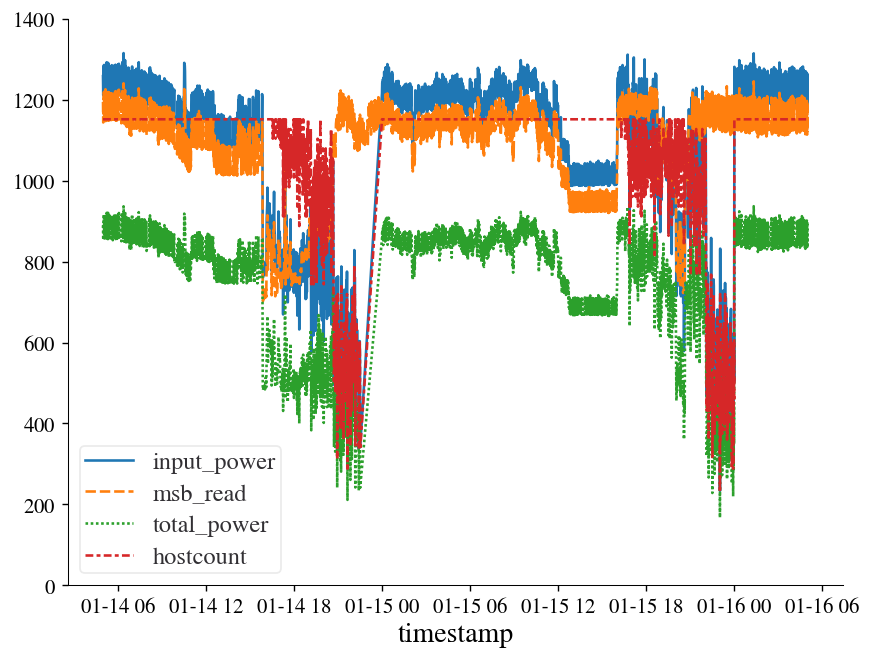

In [16]:
pal = dict(Lunch="seagreen", Dinner=".7")
data = msb_df[['input_power', 'msb_read', 'total_power', 'hostcount']].resample(pd.Timedelta(seconds=60)).mean()
sns.lineplot(data=data)

# Plotting differences and compensation

In [40]:
# Select 12 hours worth of data from 1/15 12:00AM to 12:00PM
sel_df = all_df[pd.to_datetime('2021-01-15 00:00:00Z'):pd.to_datetime('2021-01-15 12:00:00Z')]
lst = [('A', 'msb16'), ('B', 'msb17'), ('D', 'msb19'), ('E', 'msb20')]

# MSB A to E

In [41]:
# Data frame for measurement plot
df_lst = [
    pd.concat([
        pd.DataFrame(data={
            "MSB": rec[0],
            "Method": "meter",
            "kW": sel_df[rec[1]],
        }, index=sel_df.index),
        pd.DataFrame(data={
            "MSB": rec[0],
            "Method": "summation",            
            "kW": sel_df[('input_power.mean', 'sum', rec[1])] / 1000,
        }, index=sel_df.index),
    ]) for rec in lst
]
df_msd = pd.concat(df_lst)
df_msd

,MSB,Method,kW
timestamp,,,
2021-01-15 00:00:00+00:00,A,meter,1102.595825
2021-01-15 00:00:10+00:00,A,meter,1091.867065
2021-01-15 00:00:20+00:00,A,meter,1092.620239
2021-01-15 00:00:30+00:00,A,meter,1102.010132
2021-01-15 00:00:40+00:00,A,meter,1110.097168
...,...,...,...
2021-01-15 11:59:20+00:00,E,summation,1186.854736
2021-01-15 11:59:30+00:00,E,summation,1186.215576
2021-01-15 11:59:40+00:00,E,summation,1186.758545


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:169: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  leg = ax.legend(handles, labels, **kwargs)


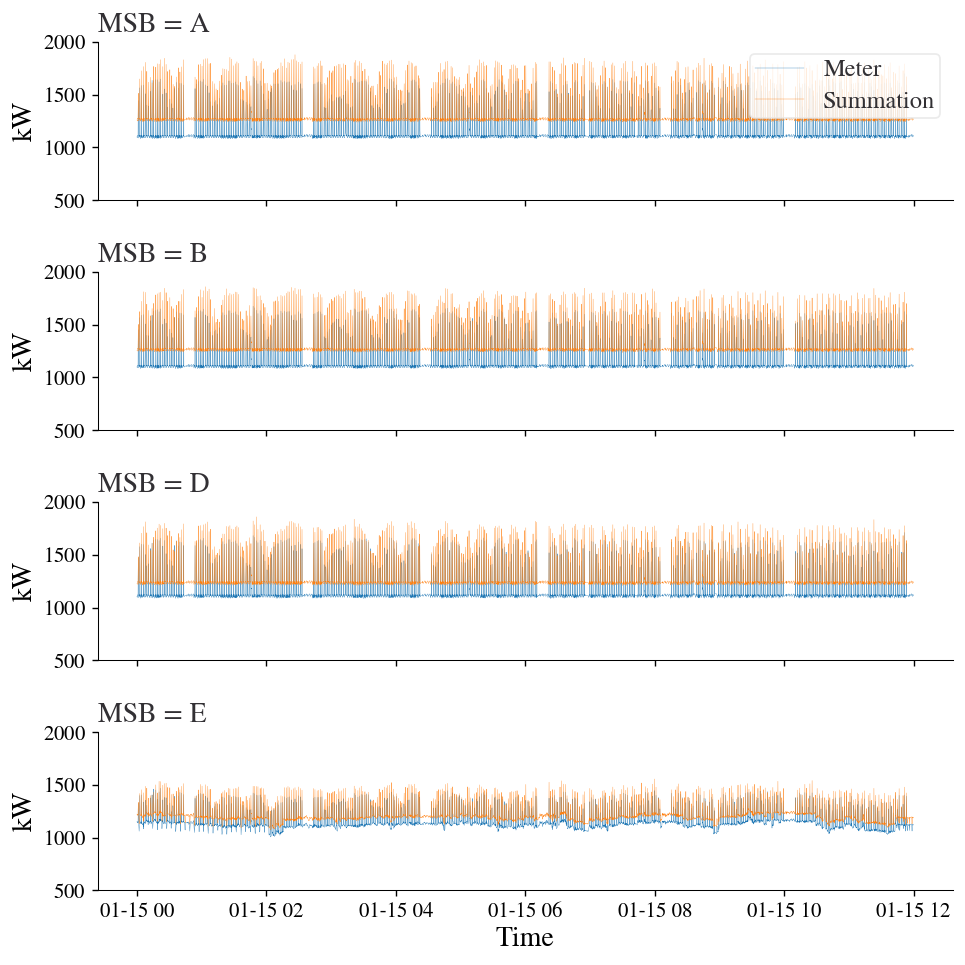

In [42]:
def measurements(facet_kws={}, line_kws={}):
    g = sns.FacetGrid(df_msd.reset_index(), col="MSB", col_wrap=1, hue="Method",
                      **width_height(height=8, columns=1, rows=4),
                     legend_out=False, **facet_kws)
    g.map(sns.lineplot, "timestamp", "kW", linewidth=0.2, **line_kws)
    g.set_axis_labels("Time", "kW")
    g.add_legend(title="", labels=["Meter", "Summation"])
measurements()

# Differences

In [220]:
# Data frame for measurement plot
df_lst = [
    pd.DataFrame(data={
            "MSB": rec[0],
            "kW Diff.": sel_df[rec[1]] - sel_df[('input_power.mean', 'sum', rec[1])] / 1000,
    }, index=sel_df.index) for rec in lst
]
df_diff = pd.concat(df_lst)
df_diff

,MSB,kW Diff.
timestamp,,
2021-01-15 00:00:00+00:00,A,-158.227539
2021-01-15 00:00:10+00:00,A,-167.009766
2021-01-15 00:00:20+00:00,A,-158.435303
2021-01-15 00:00:30+00:00,A,-157.259399
2021-01-15 00:00:40+00:00,A,-158.326538
...,...,...
2021-01-15 11:59:20+00:00,E,-68.092285
2021-01-15 11:59:30+00:00,E,-67.665283
2021-01-15 11:59:40+00:00,E,-67.410645


/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:169: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  leg = ax.legend(handles, labels, **kwargs)


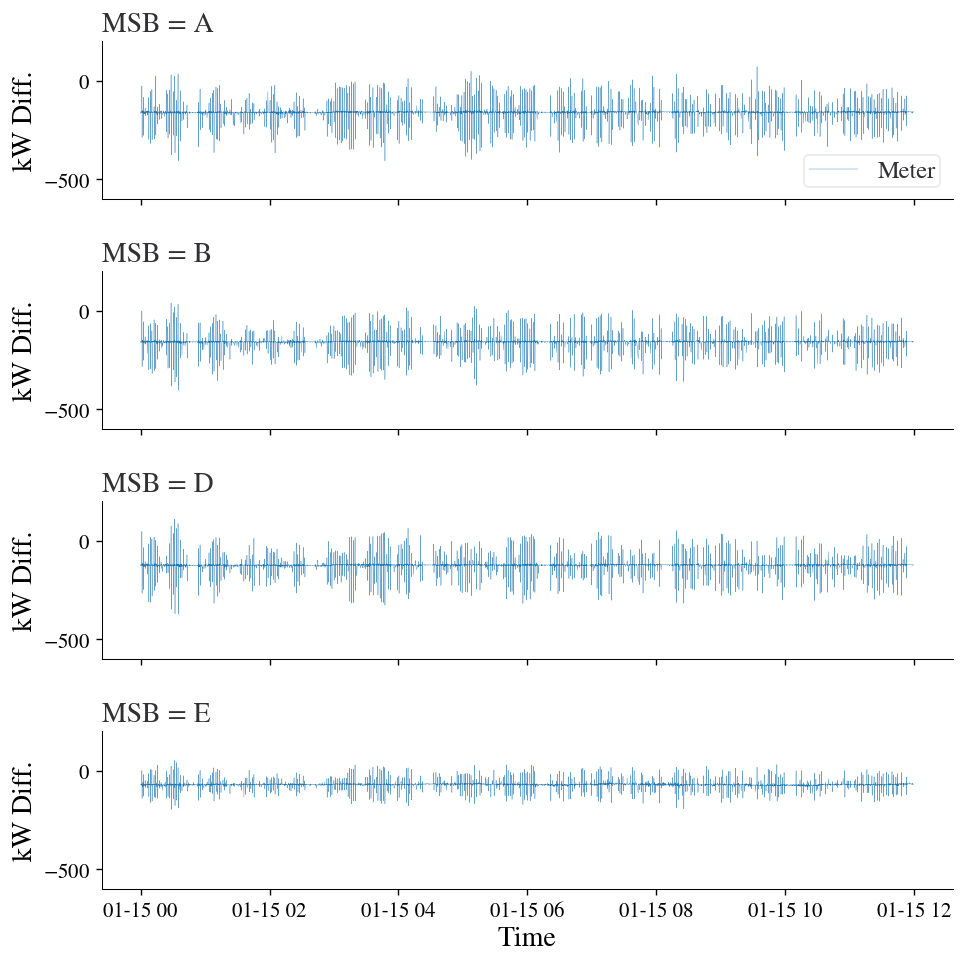

In [221]:
def differences_lineplot(facet_kws={}, line_kws={}):
    g = sns.FacetGrid(df_diff.reset_index(), col="MSB", col_wrap=1,
                      **width_height(height=8, columns=1, rows=4),
                     legend_out=False, **facet_kws)
    g.map(sns.lineplot, "timestamp", "kW Diff.", linewidth=0.2, **line_kws)
    g.set_axis_labels("Time", "kW Diff.")
    g.add_legend(title="", labels=["Meter", "Summation"])
differences_lineplot()

/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:402: RuntimeWarning: invalid value encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


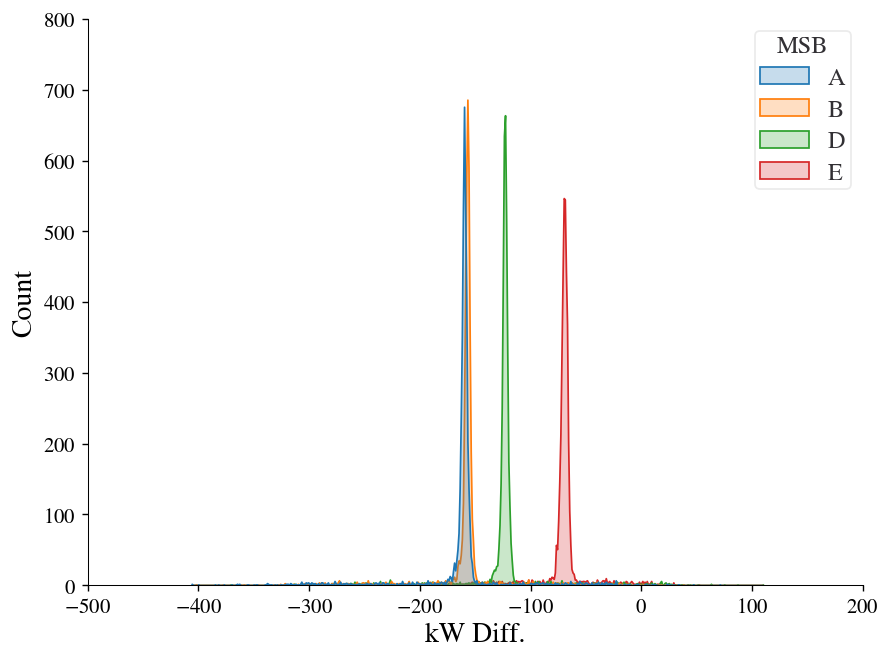

In [248]:
def differences_histplot(hist_kws={}):
    sns.histplot(df_diff, x="kW Diff.", hue="MSB", binwidth=1, element="poly", **hist_kws)
    plt.axvline(scipy.stats.gmean(df_diff['kW Diff.'], axis=0))
differences_histplot()

# Gathering them together

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


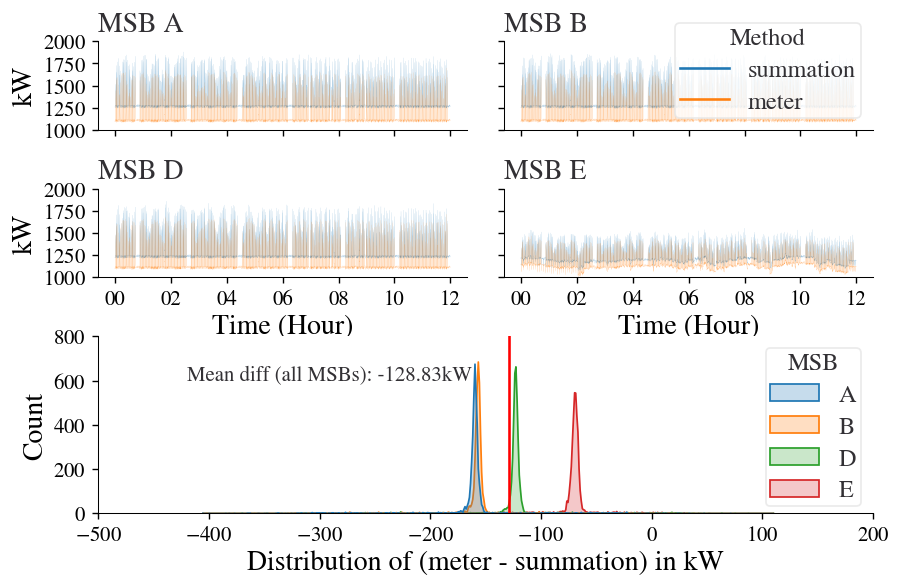

In [252]:
# Additional modules
import scipy

# initialize
plt.close()

# Override acm-ieee-latex-pubstyle
plt.figure(figsize=(8,5))
sns.despine(top=False, right=False)

# Layout
gs = mpl.gridspec.GridSpec(3,2, height_ratios=[1,1,2]) 
gs.update(hspace=0.5, wspace=0.1)

##################################################
# Comparison
def measurement(msb, ax, kwargs):
    # Measurement
    mask = (df_msd['MSB'] == msb)
    sns.lineplot(
        data=df_msd[mask].reset_index(),
        x="timestamp", y="kW",
        hue="Method", hue_order=['summation', 'meter'],
        ax=ax, **kwargs
    )

layout = [
    (0, gs[0, 0], 'A'),
    (1, gs[0, 1], 'B'),
    (2, gs[1, 0], 'D'),
    (3, gs[1, 1], 'E')
]
for i, loc, msb in layout:
    # Subplot item
    ax = plt.subplot(loc)
    kwargs = {
        "linewidth": 0.05,
        "legend": False,
    }
    # Control
    if i == 1:
        kwargs["legend"] = "auto"
    if i in (0, 1):
        plt.setp(ax.get_xticklabels(), visible=False)
    if i in (1, 3):
        plt.setp(ax.get_yticklabels(), visible=False)
    if i in (2, 3):
        # If we're on the last item...
        ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%H"))
        for item in ax.get_xticklabels():
            item.set_rotation(0)
        ax.set_xlabel("Time (Hour)")

    # Plot
    measurement(msb, ax, kwargs)
    ax.set_title(f"MSB {msb}")
    ax.set_yticks([1000, 1250, 1500, 1750, 2000])
    ax.set_ylim([1000, 2000])
    
##################################################
# Diff (take the geographic mean of the absolute value of the diffs)
df = -df_diff[df_diff['kW Diff.'].isna() == False]['kW Diff.']
abs_diff_gmean = - scipy.stats.gmean(df[df > 0])
diff_mean = df_diff['kW Diff.'].mean()

ax = plt.subplot(gs[2, 0:2])
sns.histplot(ax=ax, data=df_diff, x="kW Diff.", hue="MSB",
             binwidth=1, element="poly", legend=True)
ax.set_xlabel(f"Distribution of (meter - summation) in kW")
ax.axvline(diff_mean, color='r')
ax.text(-420, 600, f'Mean diff (all MSBs): {diff_mean:.02f}kW', fontsize=12)

#plt.subplots_adjust(hspace=.0)
plt.savefig("validation.pdf", format="pdf", bbox_inches='tight', pad_inches=0.01)
plt.show()